# 0.0. IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import matplotlib

from scipy.stats           import kurtosis
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML



## 0.1. Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Emanoel\anaconda3\envs\analise_de_dados\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [4]:
df_train_raw = pd.read_csv('../data/train.csv' , low_memory=False)


In [5]:
df_train_raw.sample()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
126,126,07/20/2008,Isparta,Other,IL,3,3.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,5,4,2,4,5,5,2,1,4,3,3,3.0,2.0,2.0,3.0,5,5,5,4,2,5,3,2,4015749.0


# 1.0. DATA DESCRIPTION

In [6]:
df1 = df_train_raw.copy()

## 1.1. Rename columns

In [7]:
cols_old = [ 'Id', 'OpenDate', 'City', 'CityGroup', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue' ]

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old) )

# Rename
df1.columns = cols_new

## 1.2. Data dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 137
Number of columns: 43


## 1.3. Data types

In [9]:
df1.head()

,id,open_date,city,city_group,type,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


In [10]:
# transformation date
df1['open_date'] = pd.to_datetime(df1['open_date'])

# transformation p's
df1['p2' ] = df1['p2' ].astype('int64')
df1['p3' ] = df1['p3' ].astype('int64')
df1['p4' ] = df1['p4' ].astype('int64')
df1['p13'] = df1['p13'].astype('int64') 
df1['p26'] = df1['p26'].astype('int64') 
df1['p27'] = df1['p27'].astype('int64') 
df1['p28'] = df1['p28'].astype('int64') 
df1['p29'] = df1['p29'].astype('int64') 


In [11]:
df1.dtypes

id                     int64
open_date     datetime64[ns]
city                  object
city_group            object
type                  object
p1                     int64
p2                     int64
p3                     int64
p4                     int64
p5                     int64
p6                     int64
p7                     int64
p8                     int64
p9                     int64
p10                    int64
p11                    int64
p12                    int64
p13                    int64
p14                    int64
p15                    int64
p16                    int64
p17                    int64
p18                    int64
p19                    int64
p20                    int64
p21                    int64
p22                    int64
p23                    int64
p24                    int64
p25                    int64
p26                    int64
p27                    int64
p28                    int64
p29                    int64
p30           

## 1.4. Check NA

In [12]:
df1.isna().sum()

id            0
open_date     0
city          0
city_group    0
type          0
p1            0
p2            0
p3            0
p4            0
p5            0
p6            0
p7            0
p8            0
p9            0
p10           0
p11           0
p12           0
p13           0
p14           0
p15           0
p16           0
p17           0
p18           0
p19           0
p20           0
p21           0
p22           0
p23           0
p24           0
p25           0
p26           0
p27           0
p28           0
p29           0
p30           0
p31           0
p32           0
p33           0
p34           0
p35           0
p36           0
p37           0
revenue       0
dtype: int64

## 1.5. Descriptive statistics

In [13]:
pd.set_option('float_format', '{:.3f}'.format)

In [14]:
# separação variáveis numéricas e categoricas

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [15]:
# medidas de tendência central - mean and median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# medidas de dispersão - std, min, max, range, skew, kurtosis

md1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
md2 = pd.DataFrame( num_attributes.apply( min ) ).T 
md3 = pd.DataFrame( num_attributes.apply( max ) ).T 
md4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
md5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
md6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

#concatenar

medidas = pd.concat([ct1, ct2, md2, md3, md1, md4, md5, md6 ]).T.reset_index()
medidas.columns = ['attributes', 'mean', 'median', 'min', 'max', 'std', 'range', 'skew', 'kurtosis' ]

In [16]:
medidas

,attributes,mean,median,min,max,std,range,skew,kurtosis
0,id,68.000,68.000,0.000,136.000,39.547,136.000,0.000,-1.200
1,p1,4.015,3.000,1.000,12.000,2.900,11.000,1.841,2.581
2,p2,4.350,5.000,1.000,7.000,1.417,6.000,-0.236,0.129
3,p3,4.307,4.000,0.000,7.000,1.008,7.000,0.001,2.310
4,p4,4.350,4.000,3.000,7.000,0.971,4.000,0.841,0.293
5,p5,2.007,2.000,1.000,8.000,1.205,7.000,2.414,8.269
6,p6,3.358,3.000,1.000,10.000,2.126,9.000,1.563,2.069
7,p7,5.423,5.000,1.000,10.000,2.288,9.000,0.669,0.812
8,p8,5.153,5.000,1.000,10.000,1.852,9.000,1.474,1.702
9,p9,5.445,5.000,4.000,10.000,1.828,6.000,1.727,1.656


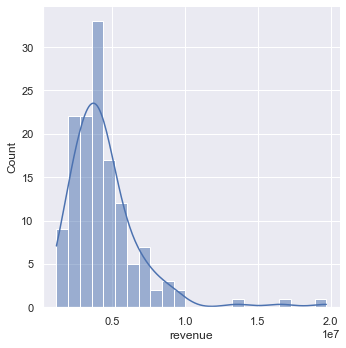

In [17]:
sns.displot( data = df1['revenue'], kde=True );

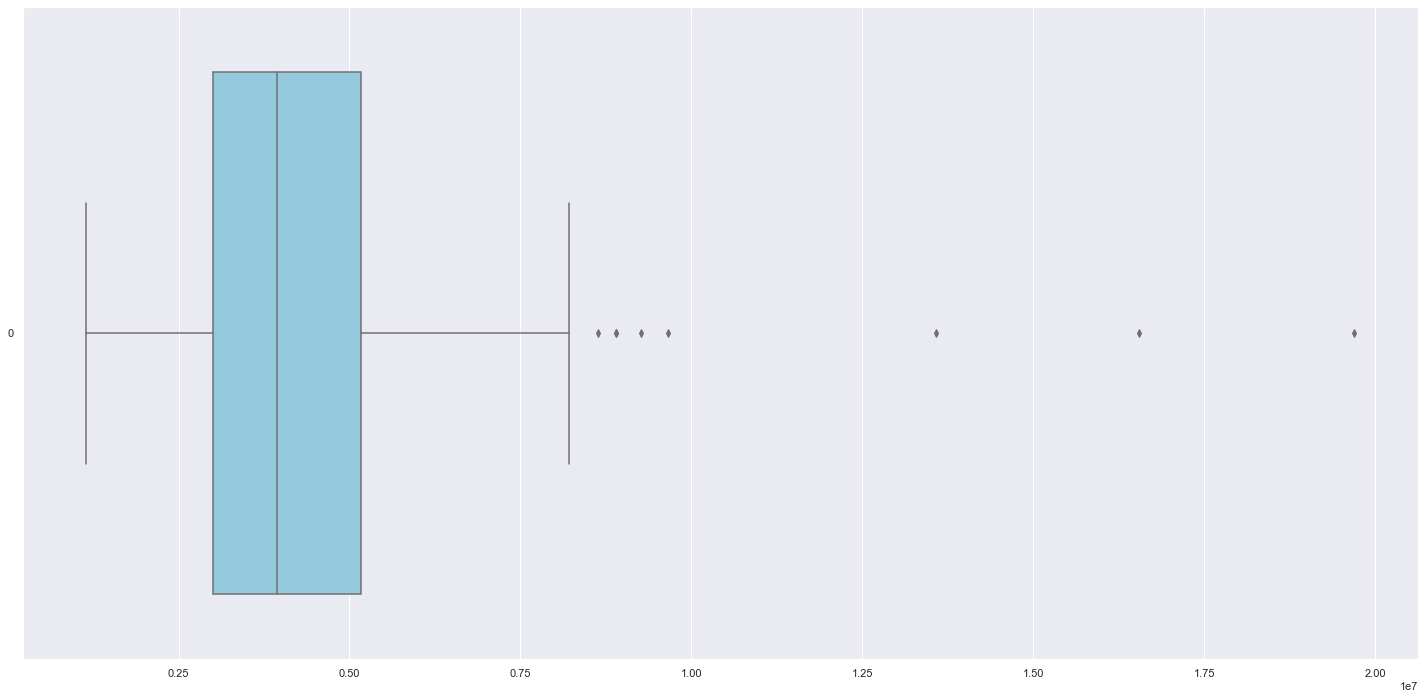

In [18]:
sns.boxplot( data = df1['revenue'], orient="h", color='skyblue' );

In [19]:
cat_attributes.apply( lambda x : x.unique().shape[0])

city          34
city_group     2
type           3
dtype: int64

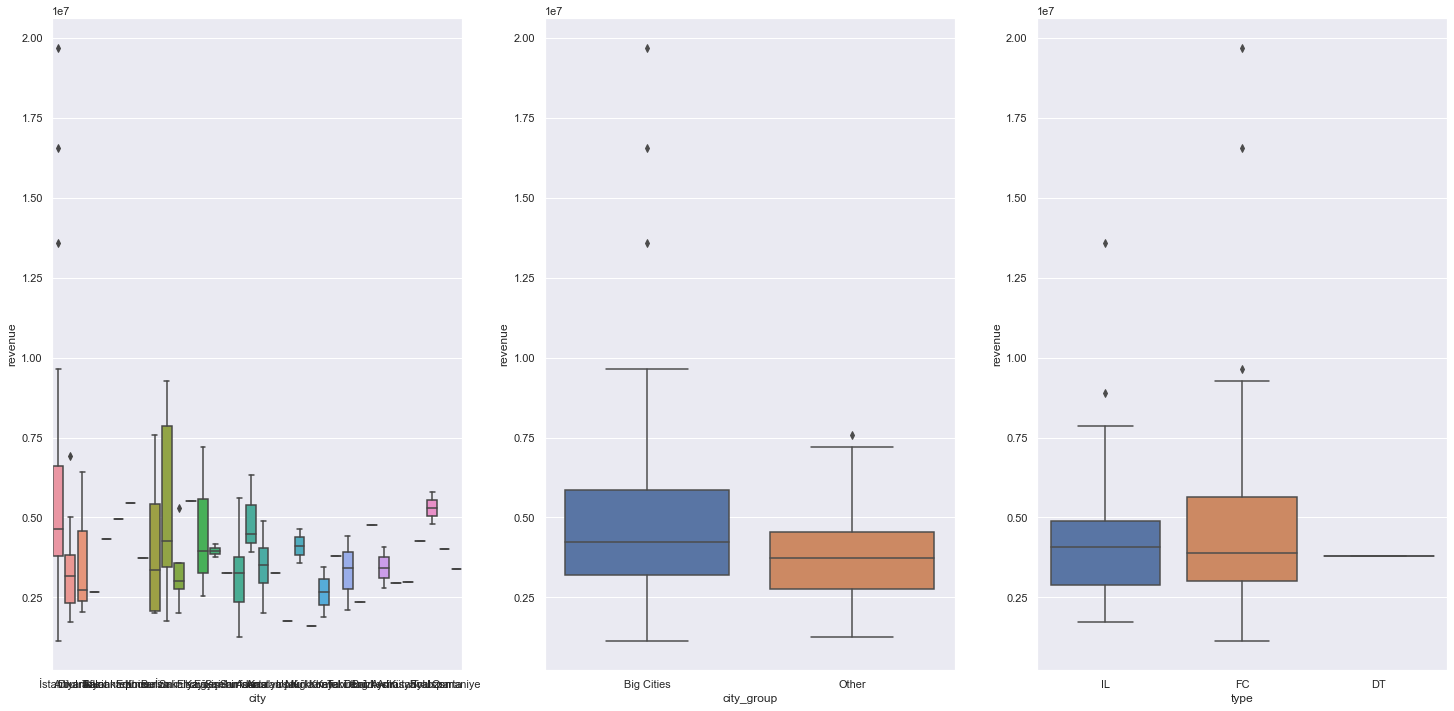

In [27]:
aux = df1[(df1['city'] != '0') & (df1['revenue'] > 0)]

plt.subplot( 1, 3, 1 );
sns.boxplot( x='city', y='revenue', data=aux );

plt.subplot( 1, 3, 2 );
sns.boxplot( x='city_group', y='revenue', data=aux );

plt.subplot( 1, 3, 3 );
sns.boxplot( x='type', y='revenue', data=aux );

# 2.0. FEATURE ENGINEERING